## **Aplicação de Regressão Linear Simples e Múltipla**
Neste notebook são aplicados os modelos de regressão linear simples e múltipla, bem como a construção de features para captura de sazonalidade e outras características das séries temporais.
Para avaliação do desempenho do modelo, serão utilizadas as métricas **MAE**, **MSE**, **RMSE** e **R²**, comparados aos modelos baseline **SARIMA** e **ETS**. 

In [1]:
# confirgurando diretório
import os
os.chdir("..")

import path
path.config()

# importando bibliotecas
import warnings
from tqdm import tqdm
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from main.features import add_calendar_features
from main.features import add_lagged_features
from main.evaluation import Evaluation
from main.plots import plot_metrics
from main.plots import plot_time_series

# configurando notebook
tqdm.pandas()

warnings.filterwarnings("ignore")

pd.set_option('display.float_format', lambda x: '%.2f' % x)

%load_ext autoreload
%autoreload 2

EVAL_PATH = 'notebooks/data/evaluation.csv'

## **Leitura dos Dados**
Leitura dos dados de treino e teste exportados no notebook *analise_exploratoria.ipynb*. Para cada série, foram separados os 70% primeiros pontos de dados para treino e o restante, ou seja, os dados mais recentes, para teste.

In [2]:
# leitura dos dados
train_df = pd.read_csv("notebooks/data/train_df.csv", parse_dates=['ds'])
test_df = pd.read_csv("notebooks/data/test_df.csv", parse_dates=['ds'])

## **Engenharia de Características**
Acrescentaremos algumas features para tentar captar a sazonalidade treinando um modelo de regressão linear múltipla.
Algums preditores são sugeridos em [Forecasting: Principles and Practice (3rd ed) - Useful Predictors](https://otexts.com/fpp3/useful-predictors.html).

In [3]:
# inserindo as features nos dados de treino e teste
features_train_df = (
    train_df
    .groupby("unique_id")
    .apply(lambda x: add_calendar_features(df=x))
    .reset_index(drop=True)
)

features_test_df = (
    test_df
    .groupby("unique_id")
    .apply(lambda x: add_calendar_features(df=x))
    .reset_index(drop=True)
)

Agora, para algumas features já criadas, serão adicionados atrasos ou adiantamentos (lags). O propósito é modelar o efeito de alguns eventos nos dias anteriores ou posteriores aos seus acontecimentos. Por exemplo: o feriado do dia 25dez tem efeito na variável não apenas no próprio dia, mas em dias anteriores ou posteriores. \
A função `add_lagged_features` desenvolvida adiciona atrasos às features de um dataframe.

In [4]:
features_test_df.columns

Index(['unique_id', 'ds', 'y', 'day', 'month_end', 'feriado', 'day_of_week',
       'week', 'month', 'quarter'],
      dtype='object')

In [5]:
# inserindo os lags nos dados de treino e teste

kwargs = {
    'features' : ['feriado', 'month_end'],
    'lags' : [-3, -2, -1, 1, 2, 3]
}

features_train_df = (
    features_train_df.groupby("unique_id")
    .apply(lambda x: add_lagged_features(df=x, **kwargs))
).reset_index(drop=True)

features_test_df = (
    features_test_df.groupby("unique_id")
    .apply(lambda x: add_lagged_features(df=x, **kwargs))
).reset_index(drop=True)

In [6]:
features_test_df.columns

Index(['unique_id', 'ds', 'y', 'day', 'month_end', 'feriado', 'day_of_week',
       'week', 'month', 'quarter', 'feriado_lag-3', 'feriado_lag-2',
       'feriado_lag-1', 'feriado_lag1', 'feriado_lag2', 'feriado_lag3',
       'month_end_lag-3', 'month_end_lag-2', 'month_end_lag-1',
       'month_end_lag1', 'month_end_lag2', 'month_end_lag3'],
      dtype='object')

Para realizar regressão linear múltipla com dados com variáveis categóricas de calendário, convém transformá-las em variáveis dummy, conforme sugerido em [Forecasting: Principles and Practice (3rd ed) - Seasonal dummy variables](https://otexts.com/fpp3/useful-predictors.html#seasonal-dummy-variables).

In [7]:
categories = ['day', 'day_of_week', 'week', 'month', 'quarter']

encoder = OneHotEncoder(drop='first')
encoder.fit(features_train_df[categories])


# aplicando nos dados de treino
X_train_encoded = pd.DataFrame(
    data = encoder.transform(features_train_df[categories]).toarray(), 
    columns=encoder.get_feature_names_out()
)

encoded_train_df = pd.concat(
    [features_train_df.drop(columns=categories), X_train_encoded], 
    axis=1
)


# aplicando nos dados de teste
X_test_encoded = pd.DataFrame(
    data = encoder.transform(features_test_df[categories]).toarray(), 
    columns=encoder.get_feature_names_out()
)

encoded_test_df = pd.concat(
    [features_test_df.drop(columns=categories), X_test_encoded], 
    axis=1
)

In [8]:
encoded_train_df.columns

Index(['unique_id', 'ds', 'y', 'month_end', 'feriado', 'feriado_lag-3',
       'feriado_lag-2', 'feriado_lag-1', 'feriado_lag1', 'feriado_lag2',
       ...
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'month_12', 'quarter_2', 'quarter_3', 'quarter_4'],
      dtype='object', length=119)

## **Regressão Linear Múltipla**

In [9]:
def multiple_linear_regression(df : pd.DataFrame) -> pd.DataFrame:
    """
    Aplicação do modelo de regressão linear múltipla.
    """    
    train = df.copy().reset_index(drop=True)
    fcst_df = encoded_test_df.query("unique_id == @train.unique_id[0]").reset_index(drop=True)

    train['trend'] = train.index
    fcst_df['trend'] = fcst_df.index + train.index.max() + 1
    
    m = LinearRegression()
    m.fit(
        X=train.iloc[:,3:], 
        y=train.y
    )
    
    fcst_df['y_pred'] = m.predict(X=fcst_df.iloc[:,3:])

    return fcst_df

In [10]:
mlr_fcst = (
    encoded_train_df.groupby("unique_id")
    .apply(multiple_linear_regression)
).reset_index(drop=True)

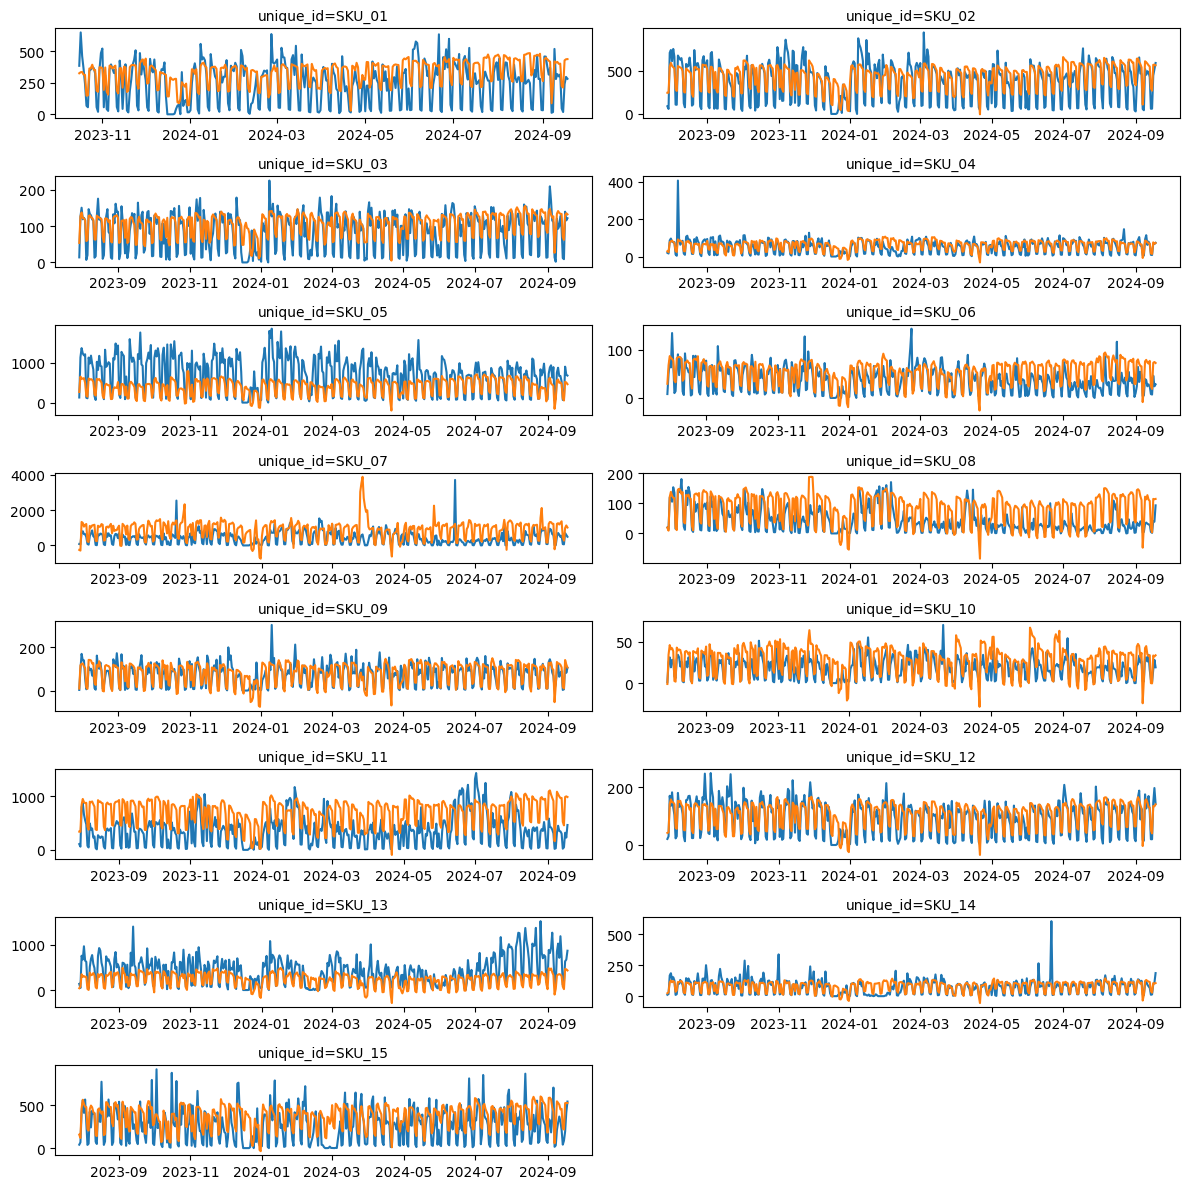

In [11]:
plot_time_series(
    df = mlr_fcst,
    data_cols=['y','y_pred'],
    grid=(8, 2),
    figsize=(12, 12)
)

In [12]:
mlr_eval = Evaluation(mlr_fcst)
mlr_eval.summary()
mlr_eval.save_evaluation(EVAL_PATH, 'Reg. Linear Multipla [+Lags]')
mlr_eval.evaluation_df

,mae,mse,rmse,r2
SKU_01,118.60,19667.42,140.24,0.30
SKU_02,121.42,21515.02,146.68,0.59
SKU_03,30.33,1379.66,37.14,0.51
SKU_04,19.16,769.78,27.74,0.47
SKU_05,338.38,198638.56,445.69,0.07
SKU_06,20.89,669.92,25.88,0.05
SKU_07,528.97,453041.97,673.08,-2.16
SKU_08,47.03,3320.82,57.63,-0.98
SKU_09,25.34,1153.58,33.96,0.56
SKU_10,12.63,242.14,15.56,-0.52


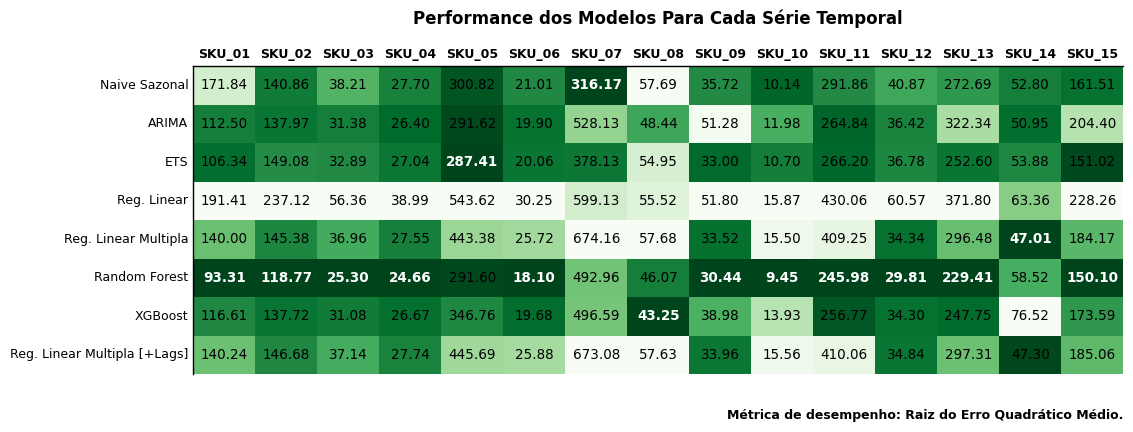

In [ ]:
# comparação dos modelos
metrics = pd.read_csv(EVAL_PATH)
order = metrics['model'].unique()
metrics = metrics.pivot_table('rmse','unique_id','model')[order]

fig = plot_metrics(metrics, figsize=(12, 4))